In [1]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import openneuro

from ndspflow.workflows.workflow import WorkFlow

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF, FOOOFGroup
from bycycle import Bycycle

# BIDS WorkFlow

Below, we fetch a BIDS dataset using the openneuro cli. Then define and execute the following workflow:

1. Load the BIDS directory using MNE BIDS
2. Apply custom functions to select channels and epoch the signal
3. Low-pass filter with neurodsp
4. Fit FOOOF
5. Fit Bycycle

In [2]:
%%capture
dataset = 'ds003844'
include = ['sub-RESP0059/ses-SITUATION1A', 'sub-RESP0280/ses-SITUATION1A']

# Create BIDs folder
bids_path = f'{os.getcwd()}/bids'

if not os.path.isdir(bids_path):
    os.makedirs(bids_path)
    
openneuro.download(dataset=dataset, target_dir=bids_path, include=include)

Re-downloading CHANGES: file size mismatch.: 0.00B [00:00, ?B/s]

Re-downloading dataset_description.json: file size mismatch.: 0.00B [00:00, ?B/s]

sub-RESP0059_ses-SITUATION1A_electrodes.json: 0.00B [00:00, ?B/s]

Skipping README: already downloaded.: 100%|##########| 4.83k/4.83k [00:00<?, ?B/s]

Skipping participants.tsv: already downloaded.: 100%|##########| 281/281 [00:00<?, ?B/s]

Skipping participants.json: already downloaded.: 100%|##########| 550/550 [00:00<?, ?B/s]

Skipping sub-RESP0059_ses-SITUATION1A_electrodes.tsv: already downloaded.: 100%|##########| 1.71k/1.71k [00:00…

Skipping sub-RESP0059_ses-SITUATION1A_task-acute_channels.tsv: already downloaded.: 100%|##########| 1.96k/1.9…

Skipping sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.json: already downloaded.: 100%|##########| 1.43k/1.43k …

Skipping sub-RESP0059_ses-SITUATION1A_task-acute_events.tsv: already downloaded.: 100%|##########| 936/936 [00…

Re-downloading sub-RESP0280_ses-SITUATION1A_channels.json: file size mismatch.: 0.00B [00:00, ?B/s]

Skipping sub-RESP0280_ses-SITUATION1A_coordsystem.json: already downloaded.: 100%|##########| 453/453 [00:00<?…

Re-downloading sub-RESP0280_ses-SITUATION1A_task-acute_channels.tsv: file size mismatch.: 0.00B [00:00, ?B/s]

Re-downloading sub-RESP0280_ses-SITUATION1A_events.json: file size mismatch.: 0.00B [00:00, ?B/s]

Skipping sub-RESP0280_ses-SITUATION1A_electrodes.tsv: already downloaded.: 100%|##########| 3.24k/3.24k [00:00…

Skipping sub-RESP0280_ses-SITUATION1A_task-acute_events.tsv: already downloaded.: 100%|##########| 121/121 [00…

Skipping sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.vmrk: already downloaded.: 100%|##########| 446/446 [00:…

Skipping sub-RESP0280_ses-SITUATION1A_task-acute_ieeg.vmrk: already downloaded.: 100%|##########| 446/446 [00:…

Re-downloading sub-RESP0059_ses-SITUATION1A_channels.json: file size mismatch.: 0.00B [00:00, ?B/s]

Skipping sub-RESP0280_ses-SITUATION1A_task-acute_ieeg.vhdr: already downloaded.: 100%|##########| 1.26k/1.26k …

Skipping sub-RESP0059_ses-SITUATION1A_coordsystem.json: already downloaded.: 100%|##########| 453/453 [00:00<?…

Re-downloading sub-RESP0280_ses-SITUATION1A_electrodes.json: file size mismatch.: 0.00B [00:00, ?B/s]

sub-RESP0059_ses-SITUATION1A_events.json: 0.00B [00:00, ?B/s]

Skipping sub-RESP0280_ses-SITUATION1A_task-acute_ieeg.json: already downloaded.: 100%|##########| 1.43k/1.43k …

Skipping sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.vhdr: already downloaded.: 100%|##########| 834/834 [00:…

Skipping sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.eeg: already downloaded.: 100%|##########| 81.2M/81.2M […

Skipping sub-RESP0280_ses-SITUATION1A_task-acute_ieeg.eeg: already downloaded.: 100%|##########| 55.4M/55.4M […

In [3]:
def select_channels(y_array, channels):
    """Select sub-set of channels."""
    inds = [ind for ind, ch in enumerate(channels)
            if ch in channels]
    
    return y_array[inds, :]
    
def epoch(y_array, n_epochs, epoch_len):
    """Epoch function."""
    y_array = y_array[:, :int(n_epochs) * epoch_len]
    y_array = y_array.reshape(-1, epoch_len)
    
    return y_array

In [4]:
wf = WorkFlow(bids_path=bids_path, session='SITUATION1A', task='acute')

wf.read_bids(subject='sub-RESP0059', allow_ragged=True)

# Custom transforms
wf.transform(select_channels, ['Gr16', 'Gr17'])
wf.transform(epoch, 2, 5000)
wf.transform(filter_signal, 'self.fs', 'lowpass', 200, remove_edges=False)

wf.fork(0)
wf.transform(compute_spectrum, 'self.fs')
wf.fit(FOOOF(verbose=False, max_n_peaks=5), (1, 100), axis=-1)

wf.fork(0)
wf.fit(Bycycle(), 'self.fs', (50, 100), axis=-1)

wf.run(n_jobs=1, progress=tqdm)

Running Workflow:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
wf.results

[[[<fooof.objs.fit.FOOOF at 0x7fc9633a5a60>,
 [[<fooof.objs.fit.FOOOF at 0x7fc9633a5eb0>,

## Inspecting Workflows
Workflows may be inspected using the `.merge` method. This executes each workflow and stores the result into the `y_array` attribute. Below, we plot the signals resulting from the preprocessing in the workflow.

In [6]:
wf = WorkFlow(bids_path=bids_path, session='SITUATION1A', task='acute')

wf.read_bids(subject='sub-RESP0059', allow_ragged=True)

# Custom transforms
wf.transform(select_channels, ['Gr16', 'Gr17'])
wf.transform(epoch, 2, 5000)
wf.transform(filter_signal, 'self.fs', 'lowpass', 200, remove_edges=False)
wf.merge()

Text(0.5, 0, 'Time (samples)')

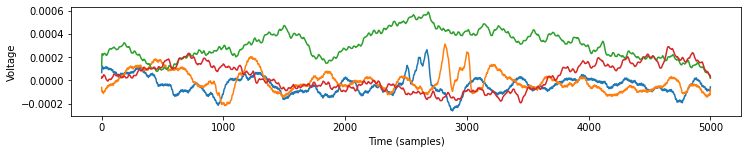

In [7]:
# Plot example channels
plt.figure(figsize=(12, 2))
for subj in wf.y_array:
    for ch in subj[2:]:
        plt.plot(ch)
        
plt.ylabel('Voltage')
plt.xlabel('Time (samples)')